In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.odr import *
from scipy import linalg
from scipy import stats
from scipy import optimize
from celluloid import Camera
import time
from tqdm.notebook import tqdm
from multiprocessing import Process
All = pd.read_csv(r'/home/jin/바탕화면/data WD/all.txt',delim_whitespace=True,header=0)
#r'C:/home/jin/바탕화면/data WD/all.txt'

plt.rcParams['font.size'] = '16'
T,R,M,Rerr, Merr,Terr = All['Teff'].to_numpy(),All['Radius'].to_numpy() ,All['Mass'].to_numpy() ,All['Rerr'].to_numpy() ,All['Merr'].to_numpy(),All['Terr'].to_numpy()

def task_multirun(pp):  
    np.random.seed(seed=pp)
    new_M = np.zeros(len(Merr))
    new_R = np.zeros(len(Rerr))
    new_T = np.zeros(len(Terr))
    for i, dM in enumerate(Merr):
        delM = stats.norm.rvs(loc=0,scale=dM)
        if (delM+ M[i])<= 0 :
            delM = 0.5* delM
        new_M[i] = M[i]+ delM
    for i, dR in enumerate(Rerr):
        delR = stats.norm.rvs(loc=0,scale=dR)
        if (delR+ R[i])<= 0 :
            delR = 0.5* delR        
        new_R[i] = R[i]+ delR   
        
    for i, dT in enumerate(Terr):
        delT = stats.norm.rvs(loc=0,scale=dT)
        if (delT+ T[i])<= 0 :
            delT = 0.5* delT        
        new_T[i] = T[i]+ delT     

    log_M = np.log10(new_M)
    log_R = np.log10(new_R)
    x = np.row_stack((log_M,new_T))
    N = 100
    
    
    TT = np.logspace(-5,5,N)
    cc = np.linspace(0,1,N)
    a_all_Model3 = np.zeros(N)
    c_T_all_Model3 = np.zeros(N)
    b_M_all_Model3 = np.zeros(N)
    resM3 = np.zeros((N,N))
    beta3 = np.zeros(N)

    c_T_all_Model4 = np.zeros(N)
    b_M_all_Model4 = np.zeros(N)
    a_all_Model4 = np.zeros(N)
    resM4 = np.zeros((N,N))
    beta4 = np.zeros(N)

    for ii, t0 in tqdm(enumerate(TT)):
        def linfit_Model3(beta,x):
            return beta[0] + beta[1]*x[0] + beta[2]*np.log10(1+x[1]/t0)
        def linfit_Model4(beta,x):
            return beta[0] + beta[1]*x[0] + np.log10(1+(x[1]/t0)**beta[2])
        data = RealData(x,log_R)  
        linmod_Model3 = Model(linfit_Model3)
        linmod_Model4 = Model(linfit_Model4)  
        odr_model3 = ODR(data,linmod_Model3,beta0=[1.,1.,1.])
        odr_model4 = ODR(data,linmod_Model4,beta0=[1.,1.,1.])  
        out_model3=odr_model3.run()
        out_model4=odr_model4.run()
        a_all_Model3[ii],b_M_all_Model3[ii],c_T_all_Model3[ii] = out_model3.beta
        a_all_Model4[ii],b_M_all_Model4[ii],c_T_all_Model4[ii] = out_model4.beta
        for jj, beta in enumerate(cc):
            R_test_Model3 = np.log10(new_R/(1+new_T/t0)**(beta))
            R_test_Model4 = np.log10(new_R/(1+(new_T/t0)**(beta)))
            resM3[ii,jj] = np.std(R_test_Model3 -b_M_all_Model3[ii]*log_M)
            resM4[ii,jj] = np.std(R_test_Model4-b_M_all_Model4[ii]*log_M)
        mm3 = resM3[ii,:].argmin()
        beta3[ii] = cc[mm3]

        mm4 = resM4[ii,:].argmin()
        beta4[ii] = cc[mm4]

    tt_m3 = np.unravel_index(resM3.argmin(),resM3.shape)
    qq , beta0_m3 = tt_m3

    tt_m4 = np.unravel_index(resM4.argmin(),resM4.shape)
    kk , beta0_m4= tt_m4
    
    R_m3 = a_all_Model3[qq]
    alpha_m3 = b_M_all_Model3[qq]
    beta_m3 = cc[beta0_m3] 
    t_m3 = TT[qq]
    res_mm3 = resM3[qq,beta0_m3]
    
    Relation_2 = np.array([[R_m3 ,alpha_m3 ,beta_m3 , t_m3 , res_mm3]])
    
    R_m4= a_all_Model4[kk]
    alpha_m4  = b_M_all_Model4[kk]
    beta_m4 = cc[beta0_m4]
    t_m4 = TT[kk]
    res_mm4 = resM4[kk,beta0_m4]
    
    Relation_3 = np.array([[R_m4 ,alpha_m4 ,beta_m4 , t_m4 , res_mm4]])
    
    file_1.open('/home/jin/바탕화면/relation_2/{}_number_data.txt'.format(pp))
    
    
    np.savetxt('/home/jin/바탕화면/relation_2/{}_number_data.txt'.format(pp), Relation_2,delimiter=',')
    np.savetxt('/home/jin/바탕화면/relation_3/{}_number_data.txt'.format(pp),Relation_3,delimiter=',')
 


if __name__ == '__main__':
    iteration = 100
    start = time.perf_counter()
 
    processes = []
    for ii in range(1,iteration+1):
        p = Process(target=task_multirun,args=[ii]) ## 각 프로세스에 작업을 등록
        p.start()
        processes.append(p)
 
    for process in processes:
        process.join()
    
    finish = time.perf_counter()
 
    print(f'{round(finish-start,2)}초 만에 작업이 완료')

20.38초 만에 작업이 완료


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.odr import *
from scipy import linalg
from scipy import stats
from scipy import optimize
from celluloid import Camera
import time
from tqdm.notebook import tqdm
from multiprocessing import Process

In [4]:
merge_df = pd.DataFrame()
file_format = ".txt" 
file_path = "/home/jin/바탕화면/test"
file = np.sort(glob.glob(f"{file_path}/*{file_format}"))

for file_name in file:
    columns = ["R0", "Alpha","Beta","T_0","STD"]
    file_df = pd.read_csv(file_name, encoding='utf-8',names=columns)
    temp_df = pd.DataFrame(file_df, columns=columns)
    merge_df = merge_df.append(temp_df) # ingnore_index = 기존 1, 2, 3, 4 번호 무시

(array([ 1.,  0.,  1.,  2., 12., 21., 27., 13., 17.,  6.]),
 array([-1.20029791, -1.16373204, -1.12716617, -1.0906003 , -1.05403443,
        -1.01746856, -0.98090269, -0.94433682, -0.90777095, -0.87120508,
        -0.83463921]),
 <a list of 10 Patch objects>)

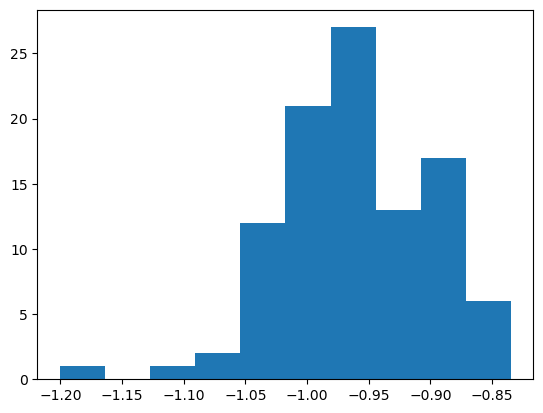

In [5]:
plt.hist(merge_df["Alpha"])